![ ](nasa-eo-fire.jpg)

Source: [NASA Earth Observatory](https://earthobservatory.nasa.gov/images/91421/fires-continue-to-rage-in-southern-california)

# A Step-By-Step Analysis of the Impacts of the Thomas Fire
## *Using Satellite & Air Quality Data in Python*

**Author:** Nicole Pepper

**Date:** 12/04/2024

The Thomas Fire, which ignited on December 4, 2017, burned approximately 281,893 acres in Ventura and Santa Barbara counties, making it one of the largest and most devastating wildfires in California's history. The fire left behind extensive burn scars with widespread loss of vegetation and unstable soil, leaving the region vulnerable to erosion. In 2018, heavy rains caused massive flooding and debris flows, which resulted in catastrophic damage and tragic loss of life.

Here I share my beginner's `Python` exercise exploring some of the impacts of the Thomas Fire using satellite imagery and air quality data.

# Part 1. Visualizing the Thomas Fire burn scar using false color

Satellite data can be used to visualize landscapes beyond what the bare eye can see. In this section I utilize true color and false color settings to visualize the Thomas Fire burn area.

Some of the technical highlights for this section include working with satellite imagery with `rioxr`, working with geospatial data with `geopandas`, and creating a map with `matplotlib`.

#### Step 1A: Set up my workspace
To begin work this exercise I set up my workspace by loading in the libraries that are necessary for the analysis:

In [1]:
# ---- Load libraries ----
import os # interacting with operating system
import numpy as np # numeric computing
import matplotlib.pyplot as plt # data visualization
import pandas as pd # general data wrangling
import geopandas as gpd # geospatial data wrangling
from shapely.geometry import Polygon # creating and manipulating geometric objects
from pyproj import CRS # crs management
import rioxarray as rioxr # working with raster data
import xarray as xr # working with arrays

Then I configure my working environment and establish a directory structure for managing the project data.

In [2]:
# ---- Set working environment ----

# Set anaconda environment
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# Set up a root path directory
root = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'hwk4_landsat_data')

#### Step 1B: Import & prepare data

Next it's time to read in my project data.

The `thomas_fire.shp` is a shapefile containing the fire perimeter for the Thomas Fire in 2017. It is subset of a CAL FIRE dataset with historical boundaries for fires (including both natural and prescribed fires) in the state of California. The dataset has a good record of past large fires but is not complete and may be missing some fires. I subset the Thomas Fire from the CAL FIRE dataset for this exercise, check out [this notebook on GitHub](https://github.com/nicolelpepper/eds220-hwk4/blob/main/hwk4-task2-fire-perimeter-PEPPER.ipynb) if you'd like to see how I did this.

The `landsat.nc` dataset is an image from Landsat Collection 2 Level-2, from the Microsof Planetary Computer data catalogue. Landsat Collection 2 Level-2 Science Products consist of atmospherically corrected surface reflectance and surface temperature image data. Collection 2 Level-2 Science Products are available from August 22, 1982 to present. It is accessed through my university but it can also be accessed on [USGS Earth Explorer](https://earthexplorer.usgs.gov/).

In [3]:
# ---- Import data ----

# Import Thomas Fire boundary
thomas_fire = gpd.read_file("data/thomas_fire/thomas_fire.shp")

# Import landsat .nc file
fp = os.path.join(root,'landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(fp)

Next, I will check the coordinate reference systems (CRS) of the `landsat` and `thomas_fire` datasets to ensure 1) the CRS aligns with the needs of the project and 2) the datasets share the same crs, allowing for  proper overlay and analysis. 

In [4]:
# ---- Check CRS information ----

# Check if landsat is projected 
print("Is the landsat CRS projected?", landsat.rio.crs.is_projected)

# Check if thomas fire is projected 
print("Is the thomas_fire CRS projected?", thomas_fire.crs.is_projected)

# Check if crs match
print("Do the crs match?", landsat.rio.crs == thomas_fire.crs)

# Print the crs name
print("The landsat CRS is:", landsat.rio.crs)

# Print the crs name
print("The thomas fire CRS is:", thomas_fire.crs.name)

Is the landsat CRS projected? True
Is the thomas_fire CRS projected? True
Do the crs match? False
The landsat CRS is: EPSG:32611
The thomas fire CRS is: WGS 84 / Pseudo-Mercator


My analysis found that the `landsat` and `thomas_fire` crs were both projected, but did not match. This means that we need to reproject the data to match. So next, I'm going to reproject the `thomas_fire` CRS is to match that `landsat` CRS which is EPSG 32611 or WGS 84 / UTM Zone 11N.

In [5]:
# ---- Reproject CRS ----

# Reproject to landsat crs
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

# Check if crs match
print("Do the crs match?", landsat.rio.crs == thomas_fire.crs)

Do the crs match? True


#### Step 1C. Explore the Data

Now that I have my data set up. I'm interested in learning more about the landsat data that I'll be using. In the next code chunk, I explore different characteristics about my data.

In [6]:
# ---- Explore data ----

# Check out landsat data dimensions
print('Size of landsat dimensions: ', dict(landsat.sizes))

# Check out the shape of the landsat data
print("The shape of Landsat is", landsat.rio.shape)

# Check out the variables of the landsat data
print("Variables in the Landsat data:", list(landsat.data_vars))

# Check out the original coordiantes of the landsat data
print("Variables in the Landsat data:", list(landsat.coords))

Size of landsat dimensions:  {'y': 731, 'x': 870, 'band': 1}
The shape of Landsat is (731, 870)
Variables in the Landsat data: ['red', 'green', 'blue', 'nir08', 'swir22']
Variables in the Landsat data: ['y', 'x', 'band', 'spatial_ref']


It looks like the `landsat` data is 870 by 731 pixels. It has has a total of a band length of 1 and the list of variables in the dataset are 'red', 'green', 'blue', 'nir08', and 'swir22'.

#### Step 1D. Prepare the landsat data for visualization

Since the landsat data only has one band, I'm going to simplify it by dropping the dimensions that so that it's easier to work with. To do this, I'll use `.squeeze()` and `.drop_vars()` to remove the band length of 1.

In [7]:
# Remove length 1 dimension (band) and reassign
landsat = landsat.squeeze().drop_vars('band', errors='ignore')

# Check updated dimensions of the coordinates
print(landsat.dims, landsat.coords)
print('Size of landsat dimensions: ', dict(landsat.sizes))

Frozen({'y': 731, 'x': 870}) Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0
Size of landsat dimensions:  {'y': 731, 'x': 870}


I can see that the extra dimension has been removed from the data! Yipee! 

### Step 1E. Visualize the Landsat data in true color

Now I want to take a look at the landsat data. First off, it would be helpful to see the study area in "natural-color" also known as "true-color', so that I can get a sense of what the terrain looks like. True-color is a term used by remote sensing experts to describe displaying a satellite image in colors similar to what most people would naturally see with their bare eyes. This means plotting the 'red', 'green', and 'blue' bands in their respective order. 

Here I plot the landsat image in true color (R-G-B) to visualize what the burn area looks like over the region.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


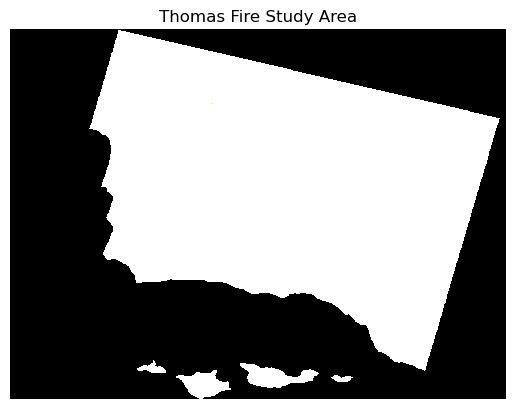

In [8]:
# Plot the landsat bands in true color
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

plt.title("Thomas Fire Study Area") # Add title
plt.axis('off') # Removing axis labels and ticks
plt.show() # Display the plot

Hmmmmm.... something here doesn't look right! The map shows up in black and white when I was expecting it to look like a true color image.

This is because the clouds in the image introduce extreme, outlier values. By setting the `robust = True` parameter in the in `.imshow()`, I adjust the color scale based on the 2nd and 98th percentiles of the values, which helps minimize the influence of these outliers. This allows the color ramp to more accurately reflect the distribution of values where most of the data lies, providing a clearer representation of the underlying true color patterns in the image.

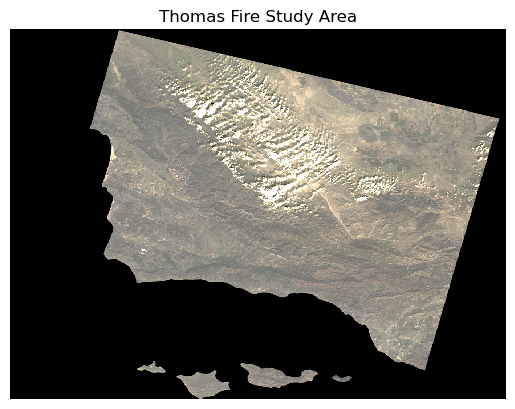

In [9]:
# Plot the landsat bands in true color
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True) # scale on the 2 & 98th percentiles

plt.title("Thomas Fire Study Area") # Add title
plt.axis('off') # Remove axis labels and ticks
plt.show() # Display the plot

Ahhh, much better! Now this is more like what I was expecting to see in my true color image.

This map helps me get a feel for what the landscape looks like, but it is still difficult for me to distinguish between landcover like healthy vegetation and bare ground, since the green, brown, and tan colors don't contrast strongly.

### Step 1F. Visualize the Landsat data in false
Next, I'd like to see if I can visualize the burned area better by integrating other bands of the landsat image in a 'false-color' composite. False-color images use at least one wavelength outside the visible range, like near-infrared, which can highlight things that we can't see with our bare eyes.

Vegetation strongly reflects in the near-infrared (NIR) and short-wave infrared (SWIR) bands and absorbs in the red, so visualizing these bands can help me distinguish between healthy vegetated from bare ground. For this reason, I will create a false-color composite using the SWIR, NIR, and red bands (SWIR-NIR-R) to better distinguish between vegetation and the Thomas Fire burned area.

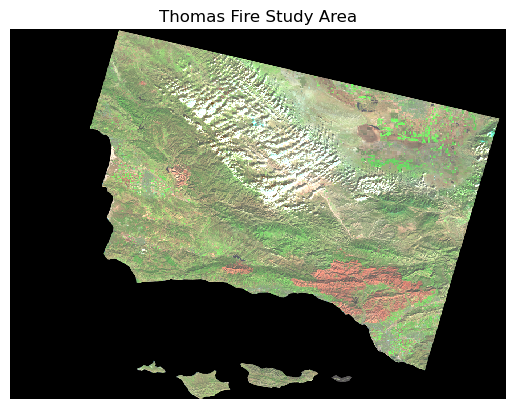

In [10]:
# Select and plot swir, nir, and red variables
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True) # scale on the 2 & 98th percentiles

plt.title("Thomas Fire Study Area") # Add title
plt.axis('off') # Remove axis labels and ticks
plt.show() # Display the plot

That worked! Now I can much more easily distinguish between vegetation (green) and bare ground or stressed vegetation (tan and red). In the bottom right, I can make out a large irregular red shape which lines up with the area that the Thomas Fire burned.

### Step 1G. Overlay the Thomas Fire boundary on the false color image

Now my final step is to overlay the false-color image with the Thomas Fire boundary to see how well the composite image picks up the burned area.

/tmp/ipykernel_2377918/2637225705.py:26: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(thomas_fire,loc='upper right', labels = ["Thomas Fire"]) # add legend


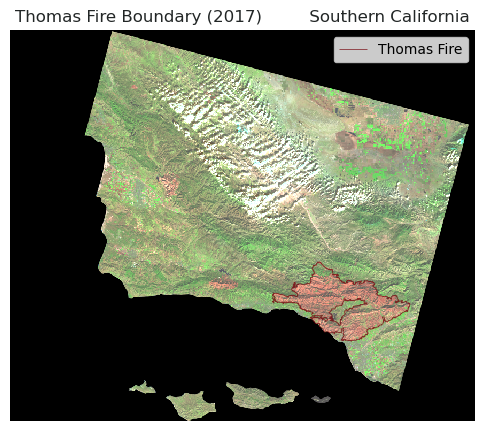

In [11]:
# ---- Create Map of Thomas Fire Boundary on False Color Image ----

# Select false color SWIR-NIR-red bands and set to array
false_color = landsat[['swir22', 'nir08', 'red']].to_array()

# Set aspect ratio for map
fire_aspect_ratio = landsat.rio.shape[1] / landsat.rio.shape[0]

# Set figure parameters
fig, ax = plt.subplots(figsize=(6, 6*fire_aspect_ratio))

# Add false color imagery for background
false_color.plot.imshow(ax = ax,
                        robust=True) 
# Add thomas fire boundary
thomas_fire.boundary.plot(ax=ax,
                color = "#780B12",
                linewidth = 0.6,
                alpha = 0.8)
# Add title
ax.set_title('Thomas Fire Boundary (2017)         Southern California',
            color="#222626", 
            fontsize=12)

ax.axis('off') # Remove axis labels and ticks
plt.legend(thomas_fire,loc='upper right', labels = ["Thomas Fire"]) # add legend
plt.show() # Display the plot

This map shows the burn perimeter, outlined in dark red, for the Thomas Fire which occured in 2017. The boundary is overlayed onto a false color satellite image of the region, combining short-wave infrared (SWIR), near-infrared (NIR), and red bands to highlight vegetation (green) versus the burn scar (red). This overlay shows that the boundary of the burn scar aligns well with area in red in false color composite. When looking back at the true color image, this false-color map demonstrates the ability of the false color images to pick out land surface characteristics beyond what our bare eyes can see.

In [12]:
# Display all columns in preview
pd.set_option("display.max.columns", None)

# Part 2. Timeseries Analysis of the Thomas Fire's Impact on Regional Air Quality

![ ](nasa-eo-smoke.jpg)

Source: [NASA Earth Observatory](https://earthobservatory.nasa.gov/images/91421/fires-continue-to-rage-in-southern-california)

In the next section, I explore the impact of the Thomas Fire on air quality using [Air Quality Index](https://www.airnow.gov/aqi/aqi-basics/) (AQI) data. The U.S Environmental Protection Agency's (EPA) AQI is a standard scale that measures air quality and its associated health impacts.

![ ](AQI.jpg)

Source: [U.S. EPA](https://www.epa.gov/)

This table shows the six AQI levels, where a higher AQI corresponds with more severe health concerns.

For this exercise I use regional AQI data from the [U.S. EPA](https://www.epa.gov/). Some of the technical highlights for this section include data wrangling with `pandas` , numerical processing with `numpy`, and time series data visualization with `matplotlib`.

### Step 2A: Set up my workspace
To begin, I set up my workspace by loading in the libraries that are necessary for the analysis:

In [13]:
# Import libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

### Step 2B: Import & prepare data

Now it's time to read in my project data!

The `aqi_17.csv` and `aqi_18.csv` are files containing AQI observations from air quality monitors for the 2017 and 2018 years, respectively, in the Thomas Fire region. I read in the data directly from the [Air Quality Index (AQI) Basics](https://www.airnow.gov/aqi/aqi-basics/) on the AirNow.gov portal.

In [14]:
# Read in AQI data
aqi_17 = pd.read_csv('data/aqi/daily_aqi_by_county_2017.zip', compression='zip')
aqi_18 = pd.read_csv('data/aqi/daily_aqi_by_county_2018.zip', compression='zip')

### Step 3C. Explore the Data

Now that I have my data set up, I'm interested in learning more about the AQI data that I'll be using. In the next code chunk, I explore different characteristics about my data.

In [15]:
# Look at the head, first 5 entries, of the AQI 2017 data
aqi_17.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,28,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,29,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,25,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,40,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,22,Good,PM2.5,01-003-0010,1


In [16]:
# b.
# Look at the head, first 5 entries, of the AQI 2018 data
aqi_18.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2018-01-02,42,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2018-01-05,45,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2018-01-08,20,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2018-01-11,25,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2018-01-14,33,Good,PM2.5,01-003-0010,1


In [17]:
# Explore the spread of AQI observation values
print("Max AQI for 2017 =", aqi_17['AQI'].max())
print("Min AQI for 2017 =", aqi_17['AQI'].min())
print("Max AQI for 2018 =", aqi_18['AQI'].max())
print("Min AQI for 2018 =", aqi_18['AQI'].min())

# Explore data types
print(aqi_17.dtypes)
print(aqi_18.dtypes)

Max AQI for 2017 = 3767
Min AQI for 2017 = 0
Max AQI for 2018 = 1051
Min AQI for 2018 = 0
State Name                   object
county Name                  object
State Code                    int64
County Code                   int64
Date                         object
AQI                           int64
Category                     object
Defining Parameter           object
Defining Site                object
Number of Sites Reporting     int64
dtype: object
State Name                   object
county Name                  object
State Code                    int64
County Code                   int64
Date                         object
AQI                           int64
Category                     object
Defining Parameter           object
Defining Site                object
Number of Sites Reporting     int64
dtype: object


I'll explain some of the results found in the data exploration above. I used `dtypes` to see the data types for the different columns. I used `max` and `min` to find the max and min AQI values for the datasets. And I used `value_counts` to find the value counts of observations that fell in the different Category Ratings

### Step 2D. Prepare the AQI data for visualization

Great, now I'm familiar with the AQI data that I'll be using, it's time to prepare it for visualization. Since `aqi_17` and `aqi_18` are saved as two separated data frames, I want to merge them together using the `pd.concat()` tool and store the output as `aqi`.

In [18]:
# ---- Combine the datasets ----

# Combine the two datasets using `pd.concat`
aqi = pd.concat([aqi_17, aqi_18])

Now that we have combined the datasets, I want to take a look at what the new dataframe looks like.

In [19]:
# ---- Explore the AQI data ----

# Check out the head of the new df
print(aqi.head())

# Check out column names
print("The column names area:", list(aqi.columns))

  State Name county Name  State Code  County Code        Date  AQI Category  \
0    Alabama     Baldwin           1            3  2017-01-01   28     Good   
1    Alabama     Baldwin           1            3  2017-01-04   29     Good   
2    Alabama     Baldwin           1            3  2017-01-10   25     Good   
3    Alabama     Baldwin           1            3  2017-01-13   40     Good   
4    Alabama     Baldwin           1            3  2017-01-16   22     Good   

  Defining Parameter Defining Site  Number of Sites Reporting  
0              PM2.5   01-003-0010                          1  
1              PM2.5   01-003-0010                          1  
2              PM2.5   01-003-0010                          1  
3              PM2.5   01-003-0010                          1  
4              PM2.5   01-003-0010                          1  
The column names area: ['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI', 'Category', 'Defining Parameter', 'Defining 

Oooof! I do not like the look of the column names. Their naming convention is all over the place, with capitalizations and spaces in the column names. This can be annoying to work with, so I'll want to tidy it up so it's easier to work with! 

I want to change my column names to `lower snake case`, a popular naming convention that uses lowercase letters and underscores to separate words.

In this next code chunk, I'm going to convert the column names to `lower snake case`, a popular naming convention that uses lowercase letters and underscores to separate words.
I'll do this by selecting the columns using `.columns`, forcing all strings (text) to lower case using `.lower()`, and replacing all spaces `' '`with underscores `'_'` using `.replace()`.

In [20]:
# Simplify column names
aqi.columns = (aqi.columns # Selects column names of the aqi df
                  .str.lower() # Forces text to lower case
                  .str.replace(' ','_') # replaces spaces ' ' with underscores '_'
                )
print("The column names are:", list(aqi.columns)) # print the updated column names

The column names are: ['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi', 'category', 'defining_parameter', 'defining_site', 'number_of_sites_reporting']


### Step 2E. Subset & prepare `aqi` data for timeseries visualization

Now that I've tidyd up my data, it's time to start some wrangling! I'm going to subset `aqi` to Santa Barbara county by selecting the column where `'county_name'` is `Santa Barbara`. I also want to remove some of the column names that I won't be using for my visualization including `'state_name'`, `'county_name'`, `'state_code'`, and `'county_code'`.

In [21]:
# ---- Subset `aqi` data for visualization ----

# Subset AQI data to Santa Barbara county
aqi = aqi[aqi['county_name'] == 'Santa Barbara']

# Remove the 'state_name', 'county_name', 'state_code' and 'county_code' columns from aqi_sb
aqi = aqi.drop(['state_name', 'county_name', 'state_code', 'county_code'], axis = 1)

Awesome, now my data is subset to my area of interest!

Next I have want to prepare the date column so that I can visualize `aqi` as a time series.

Let me check out how the date column is being stored using `type()`.

In [22]:
# Check the type of date column
date_type = type(aqi.date)
date_type

pandas.core.series.Series

Looks like it is a `pandas.core.series.Series` so I will want to update the date column to be a `pandas.datetime` object using `pd.to_datetime()`.

In [23]:
# Update the data column to datetime object
aqi.date = pd.to_datetime(aqi.date)

And now lets set the `'date'` column as the index for the `aqi` dataframe using `.set_index`.

In [24]:
# Set date as the index of aqi_sb
aqi = aqi.set_index('date')

### Step 2F. Calculate 5-Day Rolling Average for AQI

Before I create the timeseries plot, I'd like to smooth out the data a bit by calculating the average over a rolling, 5-day window. In python we can do this using `.rolling()` by specifying the window length as `'5D'` and the type of calculation to be `.mean()`.

In [25]:
# Calculate AQI rolling average over 5 days
rolling_average = (aqi['aqi']
                   .rolling(window = '5D') # Specify window length
                   .mean()) # Specify caluation as mean
rolling_average

date
2017-01-01    39.000000
2017-01-02    39.000000
2017-01-03    49.666667
2017-01-04    45.750000
2017-01-05    44.000000
                ...    
2018-12-27    41.200000
2018-12-28    38.600000
2018-12-29    38.200000
2018-12-30    38.200000
2018-12-31    38.800000
Name: aqi, Length: 730, dtype: float64

Now let's add these calculations to the `aqi` dataframe.

In [26]:
# Add calculated rolling averages as 'five_day_average' column
aqi["five_day_average"] = rolling_average

aqi

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,five_day_average
date,,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12,39.000000
2017-01-02,39,Good,PM2.5,06-083-2011,11,39.000000
2017-01-03,71,Moderate,PM10,06-083-4003,12,49.666667
2017-01-04,34,Good,Ozone,06-083-4003,13,45.750000
2017-01-05,37,Good,Ozone,06-083-4003,12,44.000000
...,...,...,...,...,...,...
2018-12-27,37,Good,Ozone,06-083-1025,11,41.200000
2018-12-28,39,Good,Ozone,06-083-1021,12,38.600000
2018-12-29,39,Good,Ozone,06-083-1021,12,38.200000


### Step 2E. Create AQI Time Series Plot for the Thomas Fire

Phew! Now that I have the data all set up, it's *finally* time to create a visualization. I'm going to plot `aqi` as a timeseries to explore how it was impacted by the Thomas Fire.

In this next code chunk, I'll create the plot along with some custom formatting elements to help provide context for the figure using `matplotlib()`. I'll set up `'date'` on the x-axis and `aqi` and `rolling_average` on the y axis.

I'll add a vertical span `plt.axvspan` and annotation `plt.annotate` in transparent red to shade in the duration of the Thomas Fire. To indicate benchmarks for 'unhealthy', 'very unhealthy', and 'hazardous' aqi levels I'll using `plt.axhline` and `plt.text` to add horizontal dashed lines.

To finish it off, I'll incorporate custom layout settings including a title, axis labels, gridlines, and a legend.

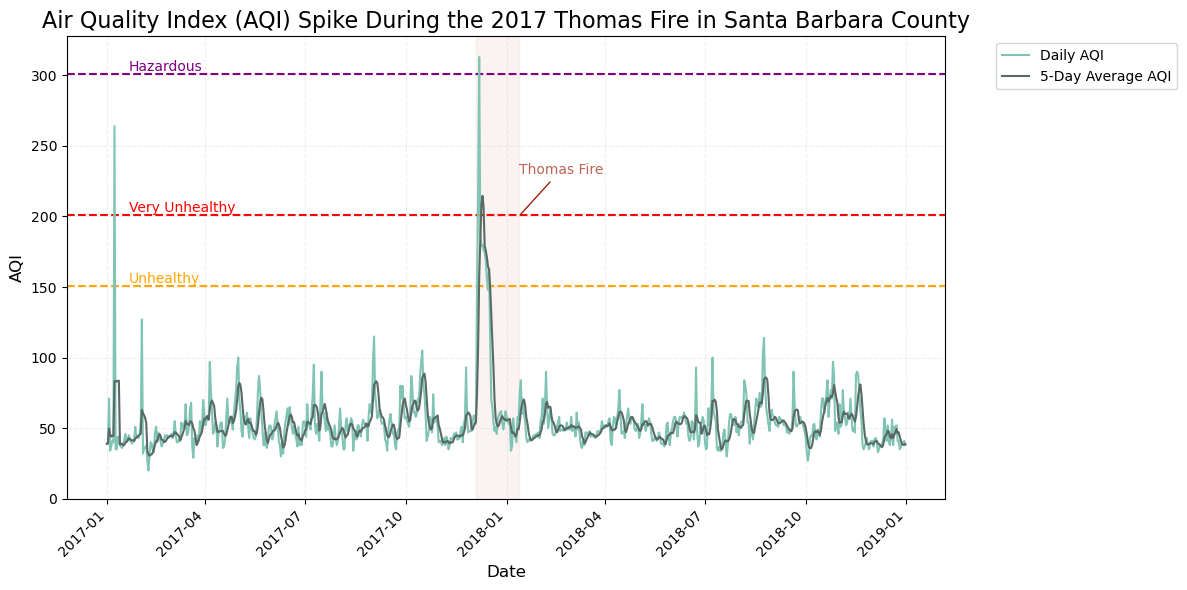

In [27]:
# Set figure size (wider plot)
fig, ax = plt.subplots(figsize=(12, 6)) 

# ---- Add vertical and horizontal labels ----

# Add vertical span indicating Thomas Fire duration
plt.axvspan(pd.to_datetime('2017-12-04'), pd.to_datetime('2018-01-12'), color ='#A3210D', alpha = 0.05)
plt.annotate('Thomas Fire', xy = (pd.to_datetime('2018-01-12'), 200), xytext = (pd.to_datetime('2018-01-12'), 230),
             arrowprops=dict(arrowstyle = '-', color='#A3210D'), color='#A3210D', alpha=0.7)

# Add dashed horizontal lines for AQI levels
plt.axhline(y=151, color = 'orange', linestyle ='--', label ='_nolegend_', linewidth=1.5)
plt.axhline(y=201, color = 'red', linestyle ='--', label ='_nolegend_', linewidth=1.5)
plt.axhline(y=301, color = 'purple', linestyle ='--', label ='_nolegend_', linewidth=1.5)

# Add text labels on the lines, moved right by a bit for better placement
plt.text(aqi.index[0] + pd.Timedelta(days = 20), 151, 'Unhealthy', color ='orange', fontsize=10, verticalalignment='bottom')
plt.text(aqi.index[0] + pd.Timedelta(days = 20), 201, 'Very Unhealthy', color ='red', fontsize=10, verticalalignment='bottom')
plt.text(aqi.index[0] + pd.Timedelta(days = 20), 301, 'Hazardous', color ='purple', fontsize=10, verticalalignment='bottom')

# ---- Plot AQI data ----

# Plot AQI and 5-day average
plt.plot(aqi.index, aqi.aqi, color='#80C4B4', label='Daily AQI')
plt.plot(aqi.index, aqi.five_day_average, color='#596964', label='5-Day Average AQI')


# ---- Customize layout ----

# Title and Labels
plt.title('Air Quality Index (AQI) Spike During the 2017 Thomas Fire in Santa Barbara County', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)

# Customize ticks
plt.xticks(rotation =45, ha ='right')
plt.yticks(range(0, 350, 50))

# Add gridlines for better readability
plt.grid(True, linestyle ='--', alpha = 0.2)

# Add Legend
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', fontsize=10)

# Show plot
plt.tight_layout() # Minimizes padding
plt.show()

This is a timeseries plot of `aqi` during the Thomas Fire in Santa Barbara County with date on the x-axis and aqi (light blue) and 5-day rolling average (dark green) on the y-axis. The figure shows a distinct spike in AQI in late 2017, during the Thomas Fire which burned from December 4, 2017 through January 12, 2018. At the start of the fire, the Daily AQI spiked above "Hazardous" AQI level, 300, which warns of emergency conditions where everyone, not just senstive populations, are likely to face health effects. The figure identifies an additional brief but significant spike in Santa Barbara, where the AQI rose above 200, which the EPA ranks as 'Very Unhealthy'; this could suggest the occurance of another fire or event that contributed to the dramatic spike.

This timeseries is an effective way to tell the story of how fires can affect AQI and pose a significant risk to human health. 

### References:

CAL FIRE (2024) *California Fire Perimeters (all)* [Data file] Available from: https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436 Access date: 11/20/24

USGS (2024) *Landsat Collection 2 Level-2 Surface Reflectance and Surface Temperature Products* [Data file]. Available from: https://www.usgs.gov/landsat-missions/landsat-collection-2 Access date: 11/20/24

EPA (2024) *Daily AQI By County 2017 & 2018* [Data file] Available from: https://www.epa.gov/ Access date: 12/04/24

Carmen Galaz García (2024) *UCSB MEDS - 220 - Working With Environmental Datasets * [Source of Homework Assignment]. Course Website: https://meds-eds-220.github.io/MEDS-eds-220-course/ Access date: 11/20/24